# Investigate ALFF calculation

In a recent PR to XCP-D, I added the ability to calculate ALFF on censored time series.
However, Joelle noticed that the ALFF maps are not strongly correlated between the old and new versions.
This may be due to a new step I added, which mean-centers and standard deviation-normalizes the time series before calculating ALFF.

I based the scaling on tests using simulated data (a signal composed of two clear frequencies), and the results were exactly the same between Lomb-Scargle and periodogram when using the settings I selected.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from nilearn import masking
from scipy import signal

sns.set_style("whitegrid")

In [2]:
def compute_alff(data_matrix, low_pass, high_pass, TR, sample_mask=None, scale=True):
    """Compute amplitude of low-frequency fluctuation (ALFF).

    Parameters
    ----------
    data_matrix : numpy.ndarray
        data matrix points by timepoints
    low_pass : float
        low pass frequency in Hz
    high_pass : float
        high pass frequency in Hz
    TR : float
        repetition time in seconds
    sample_mask : numpy.ndarray or None
        (timepoints,) 1D array with 1s for good volumes and 0s for censored ones.

    Returns
    -------
    alff : numpy.ndarray
        ALFF values.

    Notes
    -----
    Implementation based on :footcite:t:`yu2007altered`,
    although the ALFF values are not scaled by the mean ALFF value across the brain.

    If a ``sample_mask`` is provided, then the power spectrum will be estimated using a
    Lomb-Scargle periodogram
    :footcite:p:`lomb1976least,scargle1982studies,townsend2010fast,taylorlomb`.

    References
    ----------
    .. footbibliography::
    """
    # Make a copy since we're reusing the same array for multiple ALFF calculations
    data_matrix = data_matrix.copy()
    
    fs = 1 / TR  # sampling frequency
    n_voxels, n_volumes = data_matrix.shape

    if sample_mask is not None:
        sample_mask = sample_mask.astype(bool)
        assert sample_mask.size == n_volumes, f"{sample_mask.size} != {n_volumes}"

    alff = np.zeros(n_voxels)
    for i_voxel in range(n_voxels):
        voxel_data = data_matrix[i_voxel, :]
        # Check if the voxel's data are all the same value (esp. zeros).
        # Set ALFF to 0 in that case and move on to the next voxel.
        if np.std(voxel_data) == 0:
            alff[i_voxel] = 0
            continue

        if scale:
            # Normalize data matrix over time. This will ensure that the standard periodogram and
            # Lomb-Scargle periodogram will have the same scale.
            voxel_data -= np.mean(voxel_data)
            voxel_data /= np.std(voxel_data)

        if sample_mask is not None:
            voxel_data_censored = voxel_data[sample_mask]
            time_arr = np.arange(0, n_volumes * TR, TR)
            assert sample_mask.size == time_arr.size, f"{sample_mask.size} != {time_arr.size}"
            time_arr = time_arr[sample_mask]
            frequencies_hz = np.linspace(0, 0.5 * fs, (n_volumes // 2) + 1)[1:]
            angular_frequencies = 2 * np.pi * frequencies_hz
            power_spectrum = signal.lombscargle(
                time_arr,
                voxel_data_censored,
                angular_frequencies,
                normalize=True,
            )
        else:
            # get array of sample frequencies + power spectrum density
            frequencies_hz, power_spectrum = signal.periodogram(
                voxel_data,
                fs,
                scaling="spectrum",
            )

        # square root of power spectrum
        power_spectrum_sqrt = np.sqrt(power_spectrum)
        # get the position of the arguments closest to high_pass and low_pass, respectively
        ff_alff = [
            np.argmin(np.abs(frequencies_hz - high_pass)),
            np.argmin(np.abs(frequencies_hz - low_pass)),
        ]
        # alff for that voxel is 2 * the mean of the sqrt of the power spec
        # from the value closest to the low pass cutoff, to the value closest
        # to the high pass pass cutoff
        alff[i_voxel] = len(ff_alff) * np.mean(power_spectrum_sqrt[ff_alff[0] : ff_alff[1]])

    assert alff.size == n_voxels, f"{alff.shape} != {n_voxels}"

    # Add second dimension to array
    alff = alff[:, None]

    return alff

In [3]:
in_file = (
    "/Users/taylor/Documents/datasets/ds001419/derivatives/fmriprep/sub-01/func/"
    "sub-01_task-imagery_run-01_desc-preproc_bold.nii.gz"
)
mask_file = (
    "/Users/taylor/Documents/datasets/ds001419/derivatives/fmriprep/sub-01/func/"
    "sub-01_task-imagery_run-01_desc-brain_mask.nii.gz"
)
data = masking.apply_mask(in_file, mask_file)
data = data.T  # transpose to samples-by-time
low_pass = 0.08
high_pass = 0.01
# Create a binary sample mask with no flagged volumes
sample_mask = np.ones(data.shape[1], dtype=bool)

TR = 0.8

print(f"Data are shaped {data.shape}")

Data are shaped (31386, 253)


## Start by showing power spectra for different approaches

1. Don't scale the data and use periodogram (the old version).
2. Scale the data and use periodogram (the new version for uncensored data).
3. Don't scale the data and use Lomb-Scargle (unused, mostly to show effect of scaling).
4. Scale the data and use Lomb-Scargle (the new version for censored data).

In [4]:
voxel_data = data[10000, :]
fs = 1 / TR
n_volumes = voxel_data.size

# Periodogram without scaling
frequencies_hz_, power_per_noscale = signal.periodogram(
    voxel_data,
    fs,
    scaling="spectrum",
)

# Periodogram with scaling
voxel_data_scaled = voxel_data.copy()
voxel_data_scaled -= np.mean(voxel_data_scaled)
voxel_data_scaled /= np.std(voxel_data_scaled)
frequencies_hz_, power_per_scale = signal.periodogram(
    voxel_data_scaled,
    fs,
    scaling="spectrum",
)

# Lomb-Scargle without scaling
time_arr = np.arange(0, n_volumes * TR, TR)
frequencies_hz = np.linspace(0, 0.5 * fs, (n_volumes // 2) + 1)[1:]
angular_frequencies = 2 * np.pi * frequencies_hz
power_ls_noscale = signal.lombscargle(
    time_arr,
    voxel_data,
    angular_frequencies,
    normalize=True,
)

# Lomb-Scargle with scaling
power_ls_scale = signal.lombscargle(
    time_arr,
    voxel_data_scaled,
    angular_frequencies,
    normalize=True,
)

In [5]:
# Periodogram results are highly correlated regardless of scaling
print(np.corrcoef(power_per_scale, power_per_noscale)[0, 1])
# Periodogram is correlated with Lomb-Scargle if scaling is applied
print(np.corrcoef(power_per_scale[1:], power_ls_scale)[0, 1])
# Otherwise, they aren't very correlated
print(np.corrcoef(power_ls_scale, power_ls_noscale)[0, 1])
print(np.corrcoef(power_per_scale[1:], power_ls_noscale)[0, 1])

1.0
0.894362308022245
-0.0620533717140595
-0.06295458710287713


/var/folders/ph/w3cbhj9n16s9bx4l7gq3dq6m0000gn/T/ipykernel_50708/3285946068.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


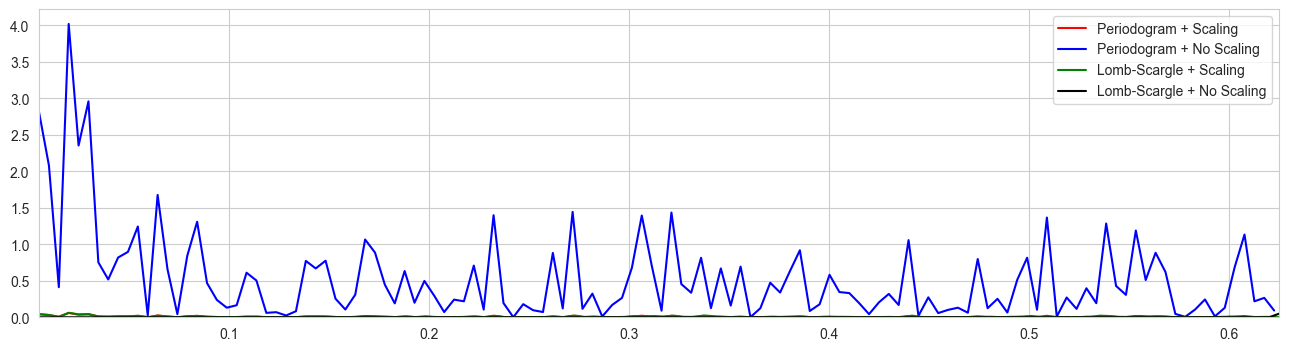

In [6]:
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(frequencies_hz_, power_per_scale, color="red", label="Periodogram + Scaling")
ax.plot(frequencies_hz_, power_per_noscale, color="blue", label="Periodogram + No Scaling")
ax.plot(frequencies_hz, power_ls_scale, color="green", label="Lomb-Scargle + Scaling")
ax.plot(frequencies_hz, power_ls_noscale, color="black", label="Lomb-Scargle + No Scaling")
ax.set_xlim(np.min(frequencies_hz), np.max(frequencies_hz))
ax.set_ylim(0, None)
ax.legend()
fig.show()

/var/folders/ph/w3cbhj9n16s9bx4l7gq3dq6m0000gn/T/ipykernel_50708/2256680535.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


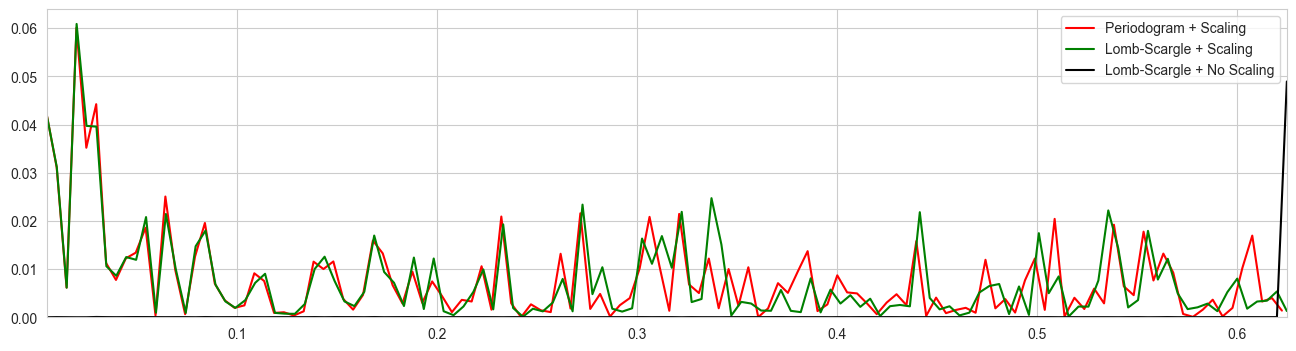

In [7]:
# Just plot the ones with similar scales
fig, ax = plt.subplots(figsize=(16, 4))
ax.plot(frequencies_hz_, power_per_scale, color="red", label="Periodogram + Scaling")
ax.plot(frequencies_hz, power_ls_scale, color="green", label="Lomb-Scargle + Scaling")
ax.plot(frequencies_hz, power_ls_noscale, color="black", label="Lomb-Scargle + No Scaling")
ax.set_xlim(np.min(frequencies_hz), np.max(frequencies_hz))
ax.set_ylim(0, None)
ax.legend()
fig.show()

## Now compare ALFF _maps_ calculated from the same data

In [8]:
alff_per_scale = np.squeeze(compute_alff(data, low_pass, high_pass, TR, sample_mask=None, scale=True))
alff_per_noscale = np.squeeze(compute_alff(data, low_pass, high_pass, TR, sample_mask=None, scale=False))
alff_ls_scale = np.squeeze(compute_alff(data, low_pass, high_pass, TR, sample_mask=sample_mask, scale=True))
alff_ls_noscale = np.squeeze(compute_alff(data, low_pass, high_pass, TR, sample_mask=sample_mask, scale=False))

In [9]:
# Scaling affects different voxels differently, so the results aren't highly correlated
print(np.corrcoef(alff_per_scale, alff_per_noscale)[0, 1])
# Scaled Lomb-Scargle and periodogram results are highly correlated
print(np.corrcoef(alff_per_scale, alff_ls_scale)[0, 1])
# Otherwise, not very correlated
print(np.corrcoef(alff_ls_scale, alff_ls_noscale)[0, 1])
print(np.corrcoef(alff_per_scale, alff_ls_noscale)[0, 1])

0.3728941230161831
0.9994655963564457
0.3547691453039091
0.35264656602226974


/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

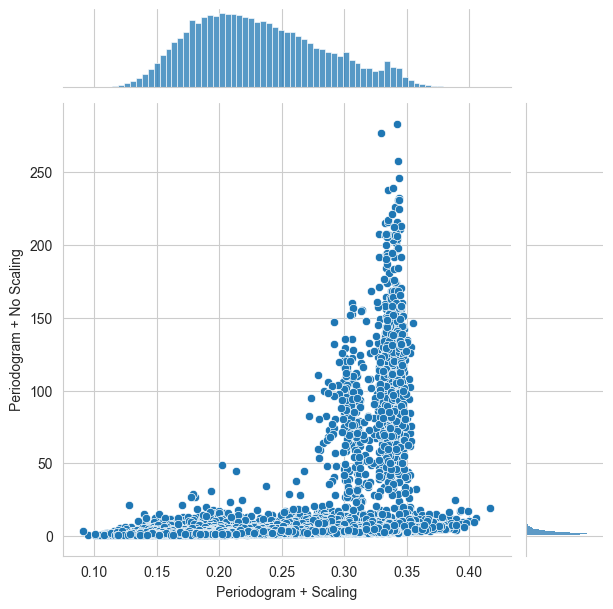

In [10]:
fig = sns.jointplot(x=alff_per_scale, y=alff_per_noscale)
fig.ax_joint.set_xlabel("Periodogram + Scaling")
fig.ax_joint.set_ylabel("Periodogram + No Scaling")
fig.figure.savefig("uncensored_alff.png")

/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

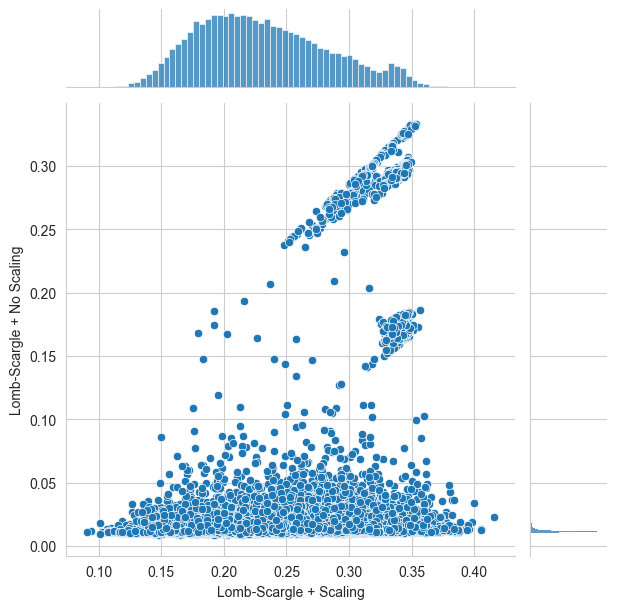

In [11]:
fig = sns.jointplot(x=alff_ls_scale, y=alff_ls_noscale)
fig.ax_joint.set_xlabel("Lomb-Scargle + Scaling")
fig.ax_joint.set_ylabel("Lomb-Scargle + No Scaling")
fig.figure.savefig("censored_alff.png")

/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

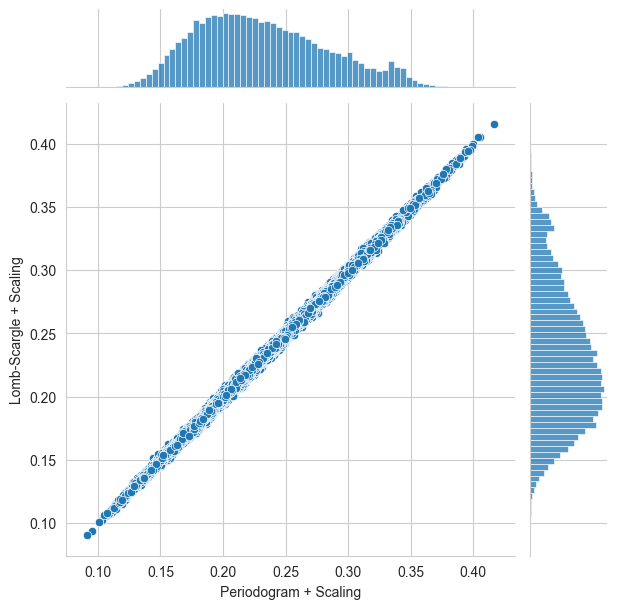

In [12]:
fig = sns.jointplot(x=alff_per_scale, y=alff_ls_scale)
fig.ax_joint.set_xlabel("Periodogram + Scaling")
fig.ax_joint.set_ylabel("Lomb-Scargle + Scaling")
fig.figure.savefig("scaled_alff.png")

/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/salo/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

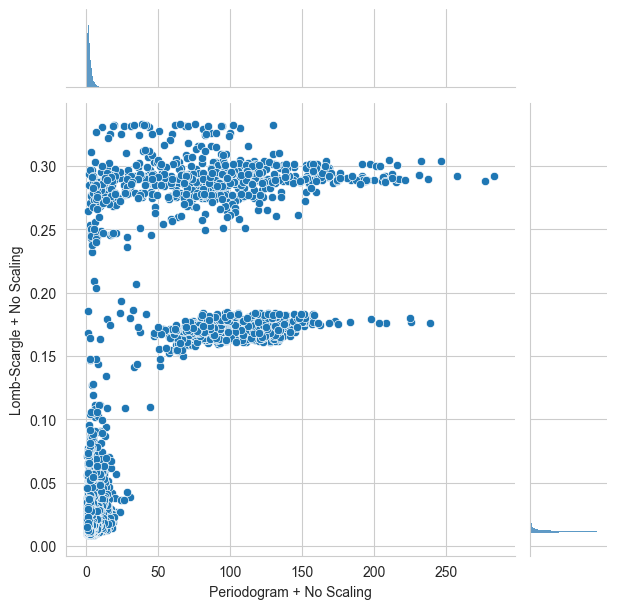

In [13]:
fig = sns.jointplot(x=alff_per_noscale, y=alff_ls_noscale)
fig.ax_joint.set_xlabel("Periodogram + No Scaling")
fig.ax_joint.set_ylabel("Lomb-Scargle + No Scaling")
fig.figure.savefig("unscaled_alff.png")